# Landcover and Landform Classification with deep neural networks

## *Virtual* "CSDMS 2020 - Linking Ecosphere and Geosphere". May 20th and 21st, 2020.

-------------------------------------
## Day 1: Constructing a Generic Image Segmentation Model

By the end of this first part we will have a generically applicable deep convolutional neural network model that can be used for a variety of image segmentation tasks at landscape and smaller scales. The model is based on the popular U-Net model. We'll see how well it works on segmenting vegetation in a couple of different aerial (UAV) datasets.

In this first part, we'll go through a complete generic workflow in `keras` for binary image segmentation (binary in the sense that there are two classes; the class of interest and background) involving custom (and customizable) functions that I've developed. I've found this workflow has been tweakable to suit a number of image segmentation tasks.

We'll utilize a few different python workflows 
* Downloading publicly available datasets from the internet and interrogating their filestructures
* Plotting imagery and label imagery as a composite, and working with colormaps to visualize the data and classes
* Making custom image and label batch generators and know how to use them
* Building a U-Net model with residual layers using `keras`, for binary segmentation 
* Compiling the model with custom loss functions and metrics
* Splitting the dataset into random train, test and validation splits with varying numbers of images 
* Training the model with custom callback functions
* Plotting training history variables in a publishable form (i.e. not using tensorboard)
* Testing the model on a test set and calculating summary statistics
* Using transfer learning to initialize a model trained on a similar dataset/class, examining the benefits of 'warm starting' a model, which is transfering the weights of a model trained one one dataset to initiate the training of another

-------------------------------------
In the next and final part, we will take that model and optimize it for a particular dataset and a multiclass segmentation problem, where we'll combine models trained on every class of interest. 

I will also stress that there are many deep learning models that do essentially the same thing, but getting them to work for you and your real-world messy data can be tricky. Along the way, I will hopefully convince you of the benefits of a specific approach for segmentation of natural scenery; namely, treating classifications as a series of binary decisions. We'll treat each class separately by considering it against a background of "everything else". That way, we can evaluate each class independently, decide of what classes to use, and we have more options to evaluate what happens in regions predicted to be more than one thing.

All the datasets used in these notebooks are publicly available and explained as they come up in the workflow

-------------------------------------
### Daniel Buscombe, daniel@mardascience.com, May 2020

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)


------------------------------------------------
## Import libraries

Libraries can be imported at any time, but it is often cleaner to define all the libraries we'll need up front.


Tensorflow is a library that allows the deployment of fast machine learning solutions on various platforms - CPU, GPU, mobile devices, etc.

It is written in C++ for speed, and wrapped in python for usability. It has its own low-level API, and also a high-level API called Keras. Keras allows construction of complex Tensorflow code using more friendly and simple syntax.

In [ ]:
import os #for accessing operating system utilities
from glob import glob #for finding files that match a certain string pattern
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
from PIL import Image #for image reading
from joblib import Parallel, delayed #for 'embarassingly parallel' computation - more later!
from numpy.lib.stride_tricks import as_strided as ast #cut an array with the given shape and strides
import random, string #for creating random strings
import tensorflow as tf #tensorflow
import requests #for downloading files from the internet
from skimage.transform import resize #for resizing images
# from psutil import virtual_memory #for displaying information about GPU and RAM in colab

-----------------------------------------------------
## Creating a "vegetation detector" 


### preparing the "Aeroscapes" dataset

The first dataset we will use is called [aeroscapes](https://github.com/ishann/aeroscapes)

The dataset consists of 3269, 720 x 720 x 3 pixel images and ground-truth masks for 11 classes. 

The classes are:
* bckgrnd
* person
* bike
* car
* drone
* boat
* animal
* obstacle
* construction
* vegetation
* road
* sky

The imagery depicts a range of urban and rural landscapes from both oblique nadir viewpoint, acquired at an altitude of 5 to 50 meters above ground from a camera on a UAV (drone). 

We download the goofle drive link made available by the authors:

Get a sorted list of images and associated labels using the `glob` function for file pattern recognition 

In [ ]:
images = sorted(glob("../data/aeroscapes/JPEGImages/*.jpg"))
labels = sorted(glob("../data/aeroscapes/SegmentationClass/*.png"))

Before we visualize some examples, let's make a nice color map so we can assign meaningful colors to the label regions corresponding with each class

We do this by first importing the `ListedColormap` function from matplotlib, that will enable us to make a discrete colormap from a list of colors

I use the combination of matploltib in-built colors (`r`,`g`,`k`,`c`,`b`,`m`,`y`) and some html color codes (see [here](https://www.w3schools.com/colors/colors_picker.asp))

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
labs = ['bckgrnd','person','bike','car','drone','boat','animal','obstacle','construction','vegetation','road', 'sky']
cols = ['k','#993333','#7589de','b','m','y','#eebfca','#e37711','r','g','#8a8d8d','c']

In [ ]:
cmap = ListedColormap(cols)

We select image and label 1000, open them and plot them using matplotlib

The bottom layer is a greyscale background image (we used the red or `0th` channel for convenience without converting to intensity)  and the top layer is the label color-coded with out custom `cmap`

(-0.5, 1279.5, 719.5, -0.5)

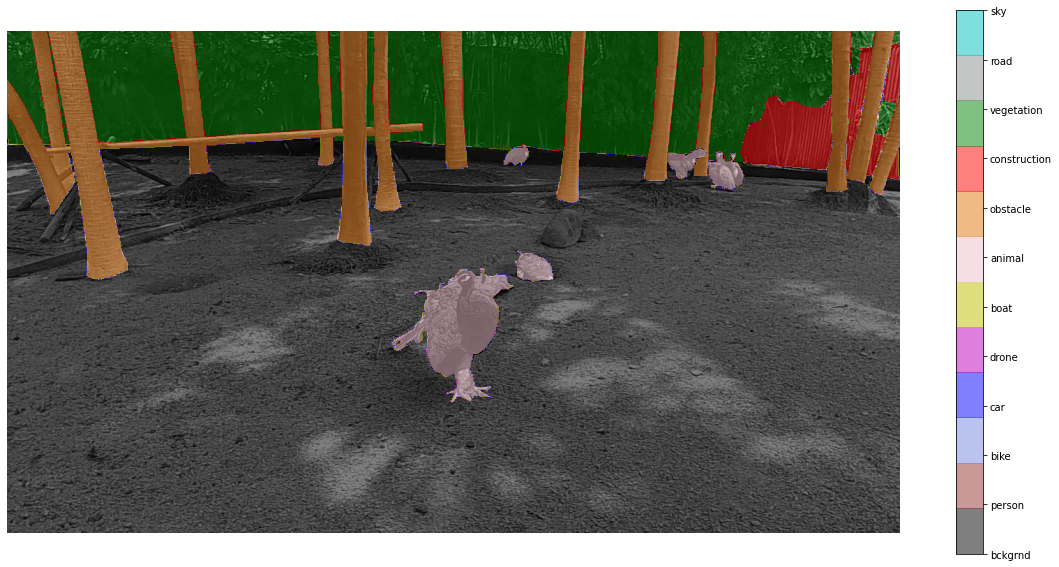

In [ ]:
label = np.array(Image.open(labels[1000]))
raw = np.array(Image.open(images[1000]))

plt.figure(figsize=(20,20))
plt.imshow(raw[:,:,0], cmap=plt.cm.gray) #plot just the first channel in greyscale
plt.imshow(label, cmap=cmap, alpha=0.5, vmin=0, vmax=11) #plot mask with 50% transparency
cbar = plt.colorbar(shrink=0.5, ticks=np.arange(12)) # make a colorbar, make it smaller and make integer tick spacing
cbar.ax.set_yticklabels(labs)  #tick labels for the colorbar

plt.axis('off')


Let's take a look at a few more, so we can get a better sense of the scope of the dataset

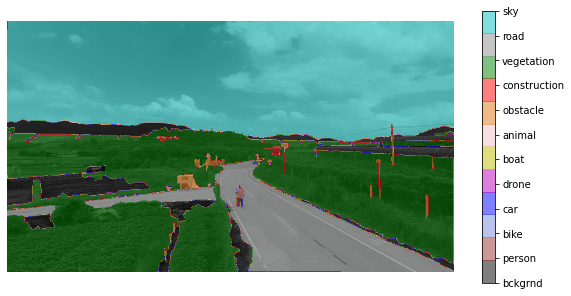

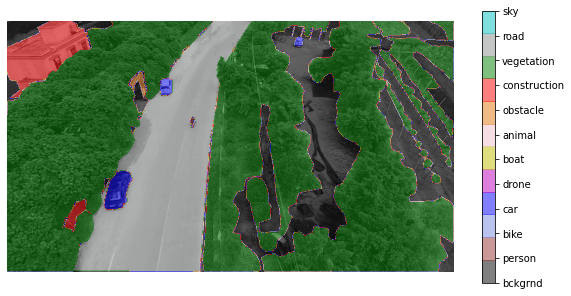

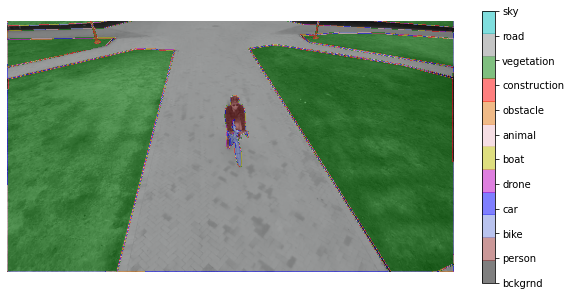

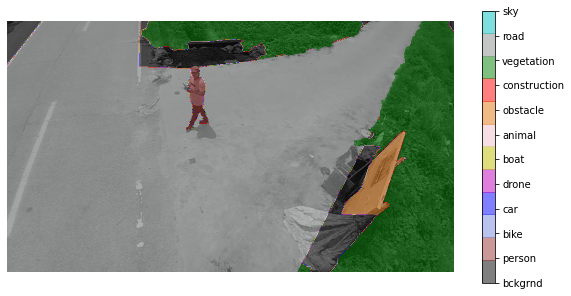

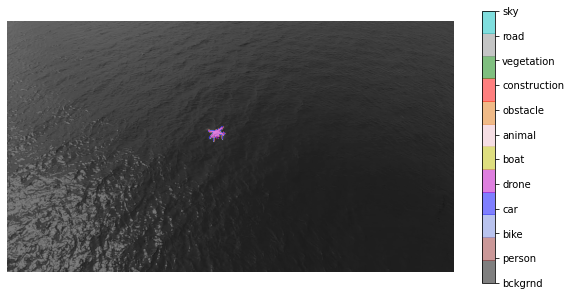

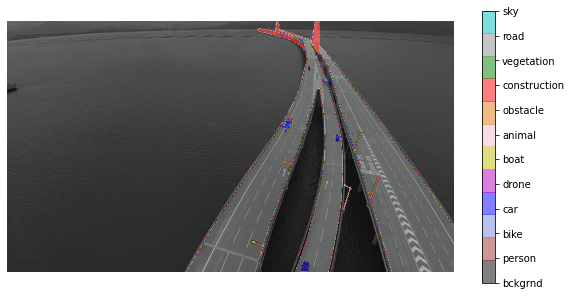

In [ ]:
for k in [0,500,1500,200,2500,3000]:
  label = np.array(Image.open(labels[k]))
  raw = np.array(Image.open(images[k]))

  plt.figure(figsize=(10,10))
  plt.imshow(raw[:,:,0], cmap=plt.cm.gray) #plot just the first channel in greyscale
  plt.imshow(label, cmap=cmap, alpha=0.5, vmin=0, vmax=11) #plot mask with 50% transparency
  cbar = plt.colorbar(shrink=0.5, ticks=np.arange(12))
  cbar.ax.set_yticklabels(labs)  #

  plt.axis('off')

Ok, we now have a good idea what the imagery and labels look like

### Setting up model training

For this task, we'll choose `vegetation` as our target class. You could choose any class, but I have a specific reason....

... after we have trained our model, we are going to use it to give the same model a training headstart to detect vegetation in another similar dataset ... more later

In [ ]:
class_num =int(np.where(np.array(labs)=='vegetation')[0])
print(class_num) 

9


In order to train a neural network to segment the image, we will need to define a image and label batch generator function. Generators are useful because it gets around memory issues associated with the alternative, which is preloading into memory all the images

The batch generator allows the data to flow to the network in stages efficiently.

Keras has some limited ability to do this built-in that I encourage you to look at, but eventually you'll run into a need to create your own custom image/label batch generator ...

so here we go ...

The function gets called repeatedly by the model duting training, generating batches of images and associated labels by drawing at random from the entire set of validation or train sets (depending on the the context in which it is called, i.e. whether or not it is fed a list of training or validation files).

In [ ]:
def image_batch_generator(files, class_num, sz, batch_size = 8):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:
        # open the image and resize
        image = np.array(Image.open(f).resize(sz))
        batch_x.append(image) #append to our growing list of images

        # open label image by string substitution and resize
        mask = np.array(Image.open(f.replace('.jpg','.png').replace('JPEGImages','SegmentationClass')).resize(sz))
        
        #return 'True' for each pixel equalling the class of interest, then convert that boolean to integer
        mask = (mask==class_num).astype('int') 
        
        batch_y.append(mask) #add to the list of lasbels

    #turn into numpy arrays and expand the dimensions of the label 
    batch_x = np.array(batch_x) 
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

We are going to feed images to the network in batches. The batch size (number of images and associated labels) will be ...

In [ ]:
batch_size = 8

The size of the imagery we will use:

In [ ]:
sz = (512, 512)

We can call the generator like so, by first creating a generator object

In [ ]:
gen = image_batch_generator(images, class_num, sz, batch_size)

then using the `next` command to `yield` sample images (`x`) and associated labels (`y`)

In [ ]:
x, y = next(gen)

In [ ]:
len(y)

8

There are `batch_size` number of `x` and `y`. Let's plot them, coloring vegetation green

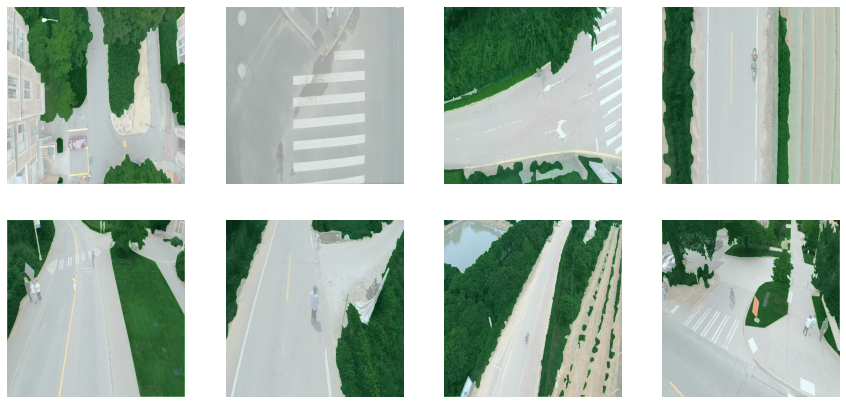

In [ ]:
plt.figure(figsize=(15,15))

counter = 0
for k in range(batch_size):
  plt.subplot(4,4,counter+1)
  plt.imshow(x[counter],  cmap=plt.cm.gray)
  plt.imshow(y[counter].squeeze(), alpha=0.5, cmap=plt.cm.Greens)
  plt.axis('off')
  counter += 1

Now we are ready to train any model. Let's build one!

### Build the model

To build and train the model, we'll need to import quite a few `keras` layers

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint #makes it easy to save the model weights while it trains as a restorable 'checkpoint'
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization #model building layers
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add #model building layers
from tensorflow.keras.models import Model #the model construction that binds all the layers together with inputs and outputs

The following definitions are used to make the residual UNet model, which is what we will be using for our binary segmentation

We'll talk about this model in more detail later while we wait for it to train. For now, we'll skip over the major details

In [ ]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
	

Segmentations of natural landscapes often involve so-called `class imbalance`. This is the situation where the average size of each class is not the same. In other words, different classes tend to occupy different amounts of pixels in imagery, on average. In the presence case, there are fewer pixels associated with smaller objects such as people and man-made objects

For binary segmentation, class imbalance can be especially bad because the `background` or `everything else` class tends to be large compared to the class of interest

This is problematic for training if it heavily biases the value of the loss function used to train the model toward the more dominant class

For these reasons, I recommend using Dice loss which tends to do better for class imbalanced problems. Scores for each class are calculated independently of their relative sizes and hence contribute fairly to the mean score.

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

# the loss is simply 1-coefficient, so its value goes down over time, not up
def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

Let's also define another metric. This one might be considered a good allternative for semantic segmentation problems like this, but isn't so effective when the problem is class imbalanced (there are not as many pixels of the class of interest as the background). 

We'll include it here as an example of passing multiple metrics to the `.optimize()` command so we can keep track of both during model training

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

Next, we make and compile our model

As we saw in lesson 1, model compilation is a necessary step, involving specifiying the 'optimizer' (we will use `rmsprop` but `adam` is also a good one to use, in my experience). The loss function is the Dice loss, and the metric we want to keep track of in the dice coefficient

We will specify input imagery of size `(512, 512, 3)`

In [ ]:
# we add (3,) to the tuple 'sz' to tell the model to ue all three image bands (R, G, and B)
model = res_unet(sz + (3,), batch_size)
model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef, mean_iou]) #'adam'

### Save and visualize model

You can reuse your model a few ways. One is to create the model object using keras layers each time. Another way is to write it out to file, so you can read it back in again

In [ ]:
model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)		

Another useful thing to do is visualize the model architecture. Perhaps the most straight-forward way to do this is print the network diagram to file

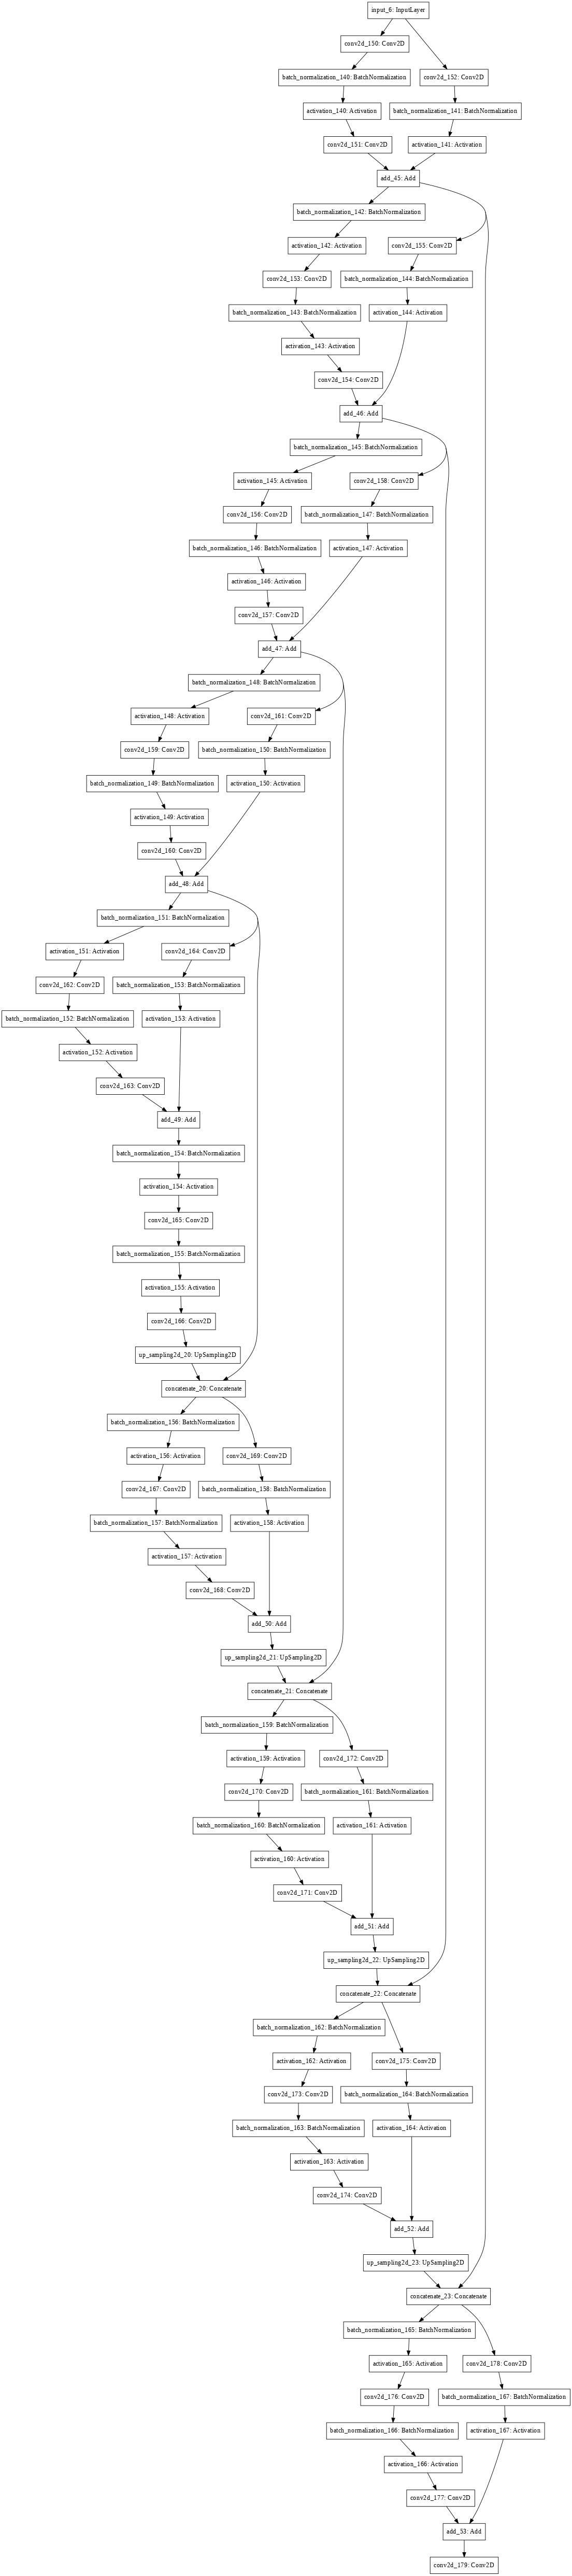

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=64
)

### Prepare the train, test and validation splits

In [ ]:
train_files = []
# open file and read the content in a list
with open('aeroscapes_train_files.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]
        # add item to the list
        train_files.append(currentPlace)

#do the same for the test files
test_files = []
with open('aeroscapes_test_files.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        test_files.append(currentPlace)

# and again for the validation files
val_files = []
with open('aeroscapes_val_files.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        val_files.append(currentPlace)

How many files do we have in each set?

In [ ]:
print("Number training files: %i" % (len(train_files)))
print("Number validation files: %i" % (len(val_files)))
print("Number testing files: %i" % (len(test_files)))

Number training files: 1635
Number validation files: 817
Number testing files: 817


### Train the model

We can use a custom callback function to see how the model is training while it trains

This must be placed within a class with only one input, `tf.keras.callbacks.Callback`. 

See https://www.tensorflow.org/guide/keras/custom_callback for more details

The following will create a plot, at the end of each training epoch, of the segmentation of one validation image using the current state of the model, while it trains

The plot consists of three images side by side: the validation image, the predicted binary mask, and the masked image showing just that class

The internal function `on_train_begin` allocates some empty lists that are subsequently filled at the end of the epoch, when `on_epoch_end` is called

In [ ]:
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
              'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'),
              'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(val_files)
        infile = f'{path}'
        raw = Image.open(infile)

        raw = np.array(raw.resize((512, 512)))

        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0)).squeeze()
                
        #mask post-processing 
        msk  = (pred>0.5).astype('int')  
      
        msk = 255*np.stack((msk,)*3, axis=-1)
          
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)

        plt.axis('off')
        plt.imshow(combined)
        plt.show()       

These are parameters that we will pass to callback functions that will adaptively change the pace of training (using an adaptive learning rate), and decide when there is little to be gained from extra training (called 'early stopping')

We set the `max_epochs` to 5, which is very small for training a deep learning model, but we'll run through this quickly to illustrate. In your own time, you should increase the number by increments, to 20, then 50, then 100 or even 200 if you need it. If the loss function has plateaued, the model won't improve any more. Later we'll look into `keras`' in-built [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) functions


In [ ]:
max_epochs = 5

Now we have defined all these hyperparameters (parameters that we chose, not automatically determined by the model), we can make a function that builds all the various callbacks together into a list, which can then be passed to the model training (`.fit()` function)

In [ ]:
def build_callbacks(filepath):

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    # make a list of callback functions
    callbacks = [model_checkpoint, PlotLearning()]

    return callbacks 

Next, set up a name for the `.h5` file that will be used to store model weights.

We are segmenting only vegetation, so we will pass 'class_num' to the batch generator functions because that is what that class appears in the list (counting from zero, as we always do in python)

Finally, we train the model by calling the `.fit()` command and providing all the generators and hyperparameters defined in the callbacks

The number of training and validation steps is simply the number of respective files divided by the batch size

In [ ]:
filepath = 'aeroscapes_weights_veg_uresnet'+str(batch_size)+'.h5' #construct a filename for the weights file

train_generator = image_batch_generator(train_files, class_num, sz, batch_size = batch_size) #call the batch generator for train set
val_generator  = image_batch_generator(val_files, class_num, sz, batch_size = batch_size) #call batch generator validation set
train_steps = len(train_files) //batch_size #number of steps per training epoch
val_steps = len(val_files) //batch_size #number of steps per validation epoch
print(train_steps)
print(val_steps)

204
102


I'll explain what this means later on ...

In [ ]:
#model.load_weights(filepath)

This takes about 10 minutes

Epoch 1/5
204/204 [==============================] - ETA: 0s - loss: 0.1291 - dice_coef: 0.8709 - mean_iou: 0.7848i= 1 loss= 0.1290557086467743 val_loss= 0.14647407829761505 dice_coef= 0.8709446787834167 val_dice_coef= 0.8535259366035461 mean_iou= 0.784769594669342 val_mean_iou= 0.7491421699523926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


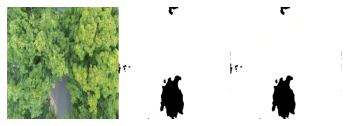

204/204 [==============================] - 108s 530ms/step - loss: 0.1291 - dice_coef: 0.8709 - mean_iou: 0.7848 - val_loss: 0.1465 - val_dice_coef: 0.8535 - val_mean_iou: 0.7491
Epoch 2/5
204/204 [==============================] - ETA: 0s - loss: 0.1093 - dice_coef: 0.8907 - mean_iou: 0.8098

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


i= 2 loss= 0.10932408273220062 val_loss= 0.11648676544427872 dice_coef= 0.890675961971283 val_dice_coef= 0.8835129737854004 mean_iou= 0.8097798824310303 val_mean_iou= 0.7951874732971191


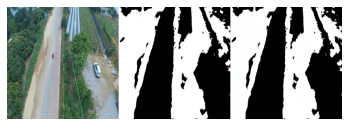

204/204 [==============================] - 106s 518ms/step - loss: 0.1093 - dice_coef: 0.8907 - mean_iou: 0.8098 - val_loss: 0.1165 - val_dice_coef: 0.8835 - val_mean_iou: 0.7952
Epoch 3/5
204/204 [==============================] - ETA: 0s - loss: 0.0986 - dice_coef: 0.9014 - mean_iou: 0.8268

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


i= 3 loss= 0.09856219589710236 val_loss= 0.10113219916820526 dice_coef= 0.9014376401901245 val_dice_coef= 0.8988677859306335 mean_iou= 0.8267613649368286 val_mean_iou= 0.8214939832687378


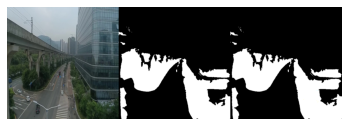

204/204 [==============================] - 106s 521ms/step - loss: 0.0986 - dice_coef: 0.9014 - mean_iou: 0.8268 - val_loss: 0.1011 - val_dice_coef: 0.8989 - val_mean_iou: 0.8215
Epoch 4/5
204/204 [==============================] - ETA: 0s - loss: 0.0904 - dice_coef: 0.9096 - mean_iou: 0.8390

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


i= 4 loss= 0.09036630392074585 val_loss= 0.08210338652133942 dice_coef= 0.9096335768699646 val_dice_coef= 0.9178967475891113 mean_iou= 0.839002251625061 val_mean_iou= 0.8511093854904175


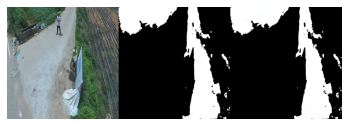

204/204 [==============================] - 106s 521ms/step - loss: 0.0904 - dice_coef: 0.9096 - mean_iou: 0.8390 - val_loss: 0.0821 - val_dice_coef: 0.9179 - val_mean_iou: 0.8511
Epoch 5/5
204/204 [==============================] - ETA: 0s - loss: 0.0838 - dice_coef: 0.9162 - mean_iou: 0.8493

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


i= 5 loss= 0.08376973867416382 val_loss= 0.08355812728404999 dice_coef= 0.9162301421165466 val_dice_coef= 0.9164420366287231 mean_iou= 0.8493306636810303 val_mean_iou= 0.8498374819755554


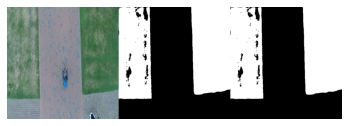

204/204 [==============================] - 106s 521ms/step - loss: 0.0838 - dice_coef: 0.9162 - mean_iou: 0.8493 - val_loss: 0.0836 - val_dice_coef: 0.9164 - val_mean_iou: 0.8498


In [ ]:
hist = model.fit(train_generator, 
                epochs = max_epochs, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = build_callbacks(filepath))	

### Examining the training history

In the above, we gave an output variable to the `.fit()` command. This contains the training histories. That is, losses and metrics as a function of epoch. You can access the variables in the dictionary like so

At this point I would recommend that you save the model weights file, called `aeroscapes_weights_vegetation_uresnet8.h5`, over in the files pane by right-clicking on the file (hit "refresh" if you don't see it) and "download". You will need them if you want to test this workflow on your own computer. Also, if the runtime gets diconnected and you lose what you have done, you can run through the cells until you get to `#model.load_weights(filepath)`, uncomment that, and it will load the weights you saved and resume model training from there

In [ ]:
hist.history.keys()

dict_keys(['loss', 'dice_coef', 'mean_iou', 'val_loss', 'val_dice_coef', 'val_mean_iou'])

Let's make a plot of the histories of both train and validation losses and dice coefficients, and also the history of the learning rate. This won't be particularly informative because we only trained for a few epochs, but it will give us an idea  

Text(0, 0.5, 'Mean IOU')

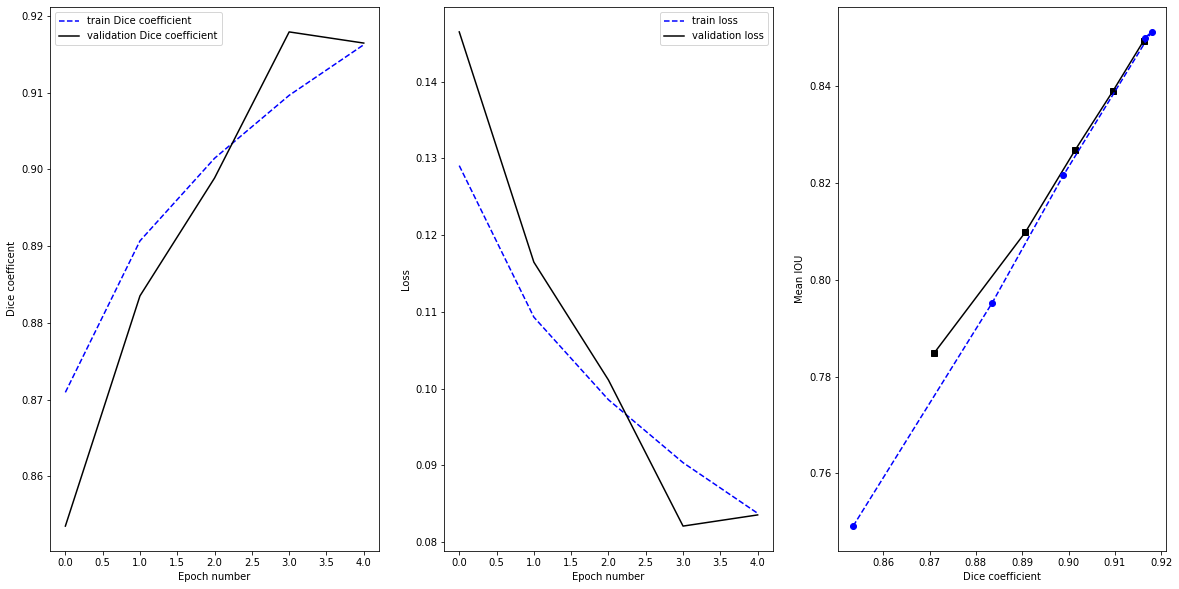

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.plot(hist.history['dice_coef'], 'b--', label='train Dice coefficient')
plt.plot(hist.history['val_dice_coef'], 'k', label='validation Dice coefficient')
plt.xlabel('Epoch number'); plt.ylabel('Dice coefficent')
plt.legend()

plt.subplot(132)
plt.plot(hist.history['loss'], 'b--', label='train loss')
plt.plot(hist.history['val_loss'], 'k', label='validation loss')
plt.xlabel('Epoch number'); plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(hist.history['dice_coef'],hist.history['mean_iou'], 'k-s')
plt.plot(hist.history['val_dice_coef'],hist.history['val_mean_iou'], 'b--o')
plt.xlabel('Dice coefficient'); plt.ylabel('Mean IOU')

Everyone will get a different set of curves because we use random subsets of training, testing and validation files 

### Test the model

The most straightfoward way to test the model on all of the test files, is to set up a batch generator like we did for train and validation sets, then use the `model.evaluate()` command to test the imagery in batches.

This approach doesn't return the segmented imagery, only the scores. It will return the loss value (the model goodness-of-fit), and whatever metrics the model was compiled with. In our case, that was the Dice coefficient and the mean IOU

In [ ]:
test_generator = image_batch_generator(test_files, class_num, sz, batch_size = batch_size)

print("# test files: %i" % (len(test_files)))

# some other training parameters
steps = len(test_files) // batch_size

# testing
scores = model.evaluate(test_generator, steps=steps) 

# test files: 817
102/102 [==============================] - 32s 309ms/step - loss: 0.0927 - dice_coef: 0.9073 - mean_iou: 0.8367


We could use string formatting to print these numbers to screen

In [ ]:
print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

loss=0.0927, Mean Dice=0.9073


In order to visualize the segmented imagery, we could generate a batch and use the `model.predict()` function on each sample. So, start by defining a new generator and `yielding` those samples using the `next` command

In [ ]:
test_generator = image_batch_generator(test_files, class_num, sz, batch_size = batch_size)
x, y = next(test_generator)

And make a prediction and plot for each in turn

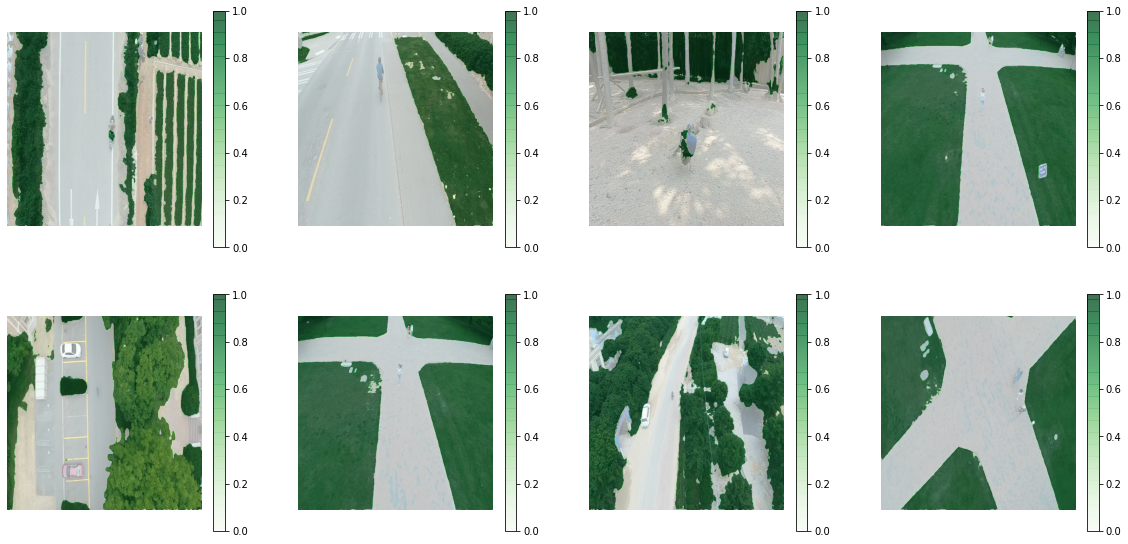

In [ ]:
plt.figure(figsize=(20,20))

for k in range(batch_size):
  plt.subplot(4,4,k+1)
  plt.imshow(x[k])

  #predict the mask 
  pred = model.predict(np.expand_dims(x[k], 0)).squeeze()
        
  # we used the sigmoid function in our classifying layer, so what we get back
  # is a range of values beween 0 and 1 that are like probability scores

  plt.imshow(pred, alpha=0.5, cmap=plt.cm.Greens, vmin=0, vmax=1)
  plt.colorbar()
  plt.axis('off')

You'll hopefully notice from the above that the model returns a likelihood of the class of interest for each pixel. A conventional way to threshold would be to assign that class to all pixels > 0.5. That is, a hard threshold. But there are other options that we'll explore later that make that deal with these values in a more probabilistic way 

For a model that was only trained with 5 epochs, this isn't too bad at all. But next we'll see what improvement you might obtain over 100 epochs. Don't worry - you won't have to weight. I already trained the model over 100 epochs, so all we need to do is download and then apply the trained model weights

In [ ]:
test_generator = image_batch_generator(test_files, class_num, sz, batch_size = batch_size)

print("# test files: %i" % (len(test_files)))

# some other training parameters
steps = len(test_files) // batch_size

# testing
scores = model.evaluate(test_generator, steps=steps) 

print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

# test files: 817
102/102 [==============================] - 32s 310ms/step - loss: 0.0239 - dice_coef: 0.9761 - mean_iou: 0.9535
loss=0.0239, Mean Dice=0.9761


As you can see, the mean score is higher (the difference between training the model on 5 versus 100 epochs is much larger for other classes - I encourage you to explore)

In [ ]:
test_generator = image_batch_generator(test_files, class_num, sz, batch_size = batch_size)

x, y = next(test_generator)

This time we'll resize the image and label to the original size, which in this case increases the image from 512x512 to 720x720 pixels.

This is done using the `Image` library `fromarray` and `resize` commands

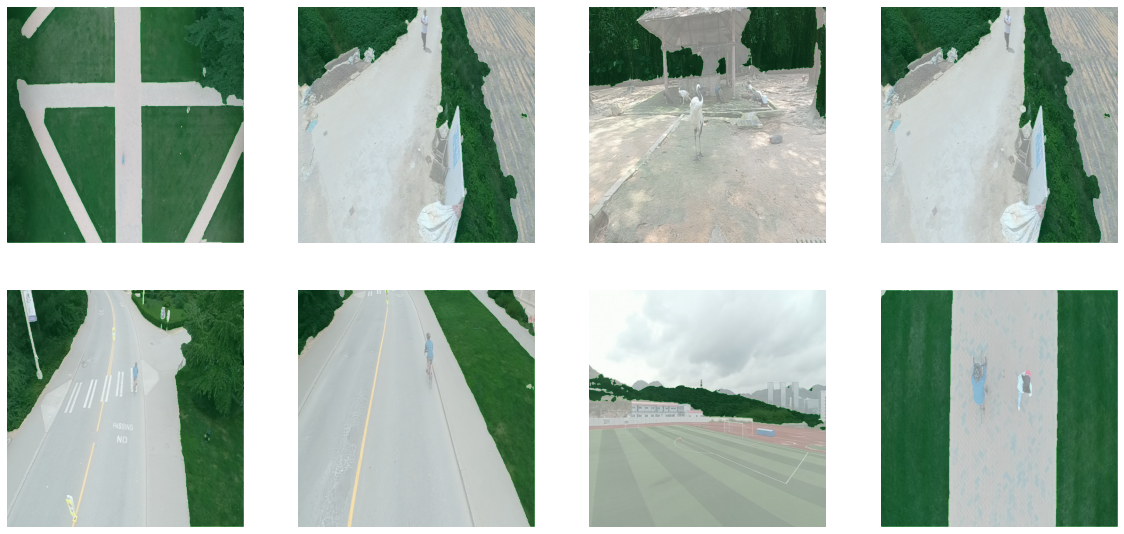

In [ ]:
plt.figure(figsize=(20,20))

orig_size = (720, 720)

for k in range(batch_size): #cycle through k images in the batch
  plt.subplot(4,4,k+1) #make a new subplot (subplots are indexed from 1, not 0)

  resized_image = Image.fromarray(x[k]).resize(orig_size) #load image and resize
  plt.imshow(resized_image) #plot image

  #predict the mask 
  # we expand the dimensions (because the model needs a 4d tensor input) then squeeze the 
  # output dimensions down from 3d to 2d
  pred = model.predict(np.expand_dims(x[k], 0)).squeeze()

  resized_label = np.array(Image.fromarray(pred).resize(orig_size))

  #mask post-processing 
  # we used the sigmoid function in our classifying layer, so what we get back
  # is a range of values beween 0 and 1 that are like probability scores
  # I used a threshold of 0.5, but that could be different if you knew different
  msk  = (resized_label>0.5).astype('int')   

  plt.imshow(msk, alpha=0.5, cmap=plt.cm.Greens)
  plt.axis('off')

------------------------------------------------------
## Recap so far

Before we move on to the next step, let's recap what we have done so far

* Downloaded the `aeroscapes` dataset
* Defined a colormap and visualized the imagery using semi-transparent overlays of the color-coded label images
* Made a custom image/label batch generator that can be used by a deep learning model for segmentation
* Made a U-Net with residual connections (the "model") and trained it with train and validation image/label subsets, drawn randomly from all the available images
* Trained said model to segment a particular class - we chose 'vegetation'
* Plotted training history variables
* Testing the model on an independent (i.e. never seen by the model) test set and calculating summary statistics

In the last part of this notebook, I'll demonstrate how you could do something similar with another dataset, but this time you'll give yourself a head-start

By using the same model architecture, you can simply transfer the model `weights` learned during training, to another model that will subsequently refine those weights for that second data. This general principle is called `transfer learning` (although there are many types beyond this specific one) 

We'll see that we can 'hot start' a model training in this way, potentially allowing more efficient and quicker training



----------------------------------------------------
## Transfer learning to a similar data set

In this part, we are going to take our model weights and use them to train a new model on a similar class in a different data set

This is one `transfer learning` strategy we could employ.

The repurposing of models and their pretrained weights - called `transfer learning` is extremely common and encouraged in the computer science community. It allows more efficient training of models, which translates into small model training times and less energy consumption

Often, there is something generic about the 'features’ that models exploit for classification, so for that reason alone it is often worth carrying out transfer learning


### Prepare the "semantic drone" data

The dataset is available [here](https://www.tugraz.at/index.php?id=22387) and consists of 400 images and associated binary masks of 23 categories. For speed, we will be working with a random subset of these data (100 images and associated masks), but the same workflow would be appropriate for the entire dataset.

The imagery depicts houses from nadir view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000 x 4000 px (24 Mpx). 

The classes are:
* unlabeled
* paved-area
* dirt
* grass
* gravel
* water
* rocks
* pool
* vegetation
* roof
* wall
* window
* door
* fence
* fence-pole
* person
* dog
* car
* bicycle
* tree
* bald-tree
* ar-marker
* obstacle
* conflicting


Perhaps the easiest way to parse all these files is to use the `os.walk` command simply to step through all files in the `quarter` folder. Then we'll create separate image and label lists based on file extension

In [ ]:
F = []
for k in os.walk('../data/semdrone/'):
   F.append(k)

In [ ]:
all_images = sorted(F[0][2])
images = [i for i in all_images if 'jpg' in i]
labels = [i for i in all_images if 'png' in i]

How many images do we have?

In [ ]:
print('%i image files ' % (len(images)))
print('%i label files ' % (len(labels)))

100 image files 
100 label files 


Below is a class dictionary, which consists of class names and their RGB colors in the label image

In [ ]:
class_dict = [('unlabeled',	0,	0,	0),
('paved-area',	128,	64,	128),
('dirt',	130,	76,	0),
('grass',	0,	102,	0),
('gravel',	112,	103,	87),
('water',	28,	42,	168),
('rocks',	48,	41,	30),
('pool',	0,	50,	89),
('vegetation',	107,	142,	35),
('roof',	70,	70,	70),
('wall',	102,	102,	156),
('window',	254,	228,	12),
('door',	254,	148,	12),
('fence',	190,	153,	153),
('fence-pole',	153,	153,	153),
('person',	255,	22,	96),
('dog',	102,	51,	0),
('car',	9,	143,	150),
('bicycle',	119,	11,	32),
('tree',	51,	51,	0),
('bald-tree',	190,	250,	190),
('ar-marker',	112,	150,	146),
('obstacle',	2,	135,	115),
('conflicting',	255,	0,	0)]

We'll make a separate list only of the class names

In [ ]:
labs_txt = [c[0] for c in class_dict]

In [ ]:
labs_txt

['unlabeled',
 'paved-area',
 'dirt',
 'grass',
 'gravel',
 'water',
 'rocks',
 'pool',
 'vegetation',
 'roof',
 'wall',
 'window',
 'door',
 'fence',
 'fence-pole',
 'person',
 'dog',
 'car',
 'bicycle',
 'tree',
 'bald-tree',
 'ar-marker',
 'obstacle',
 'conflicting']

The images list needs to be pre-pended with the top level folder name, to be discoverable

In [ ]:
images = ['semdrone/'+i for i in images]
labels = ['semdrone/'+i for i in labels]

This simple function opens, resizes and returns images and associated labels as numpy arrays

In [ ]:
def get_pair(im, lab, sz):

    label = np.array(Image.open(lab).resize(sz,  Image.NEAREST))
    raw = np.array(Image.open(im).resize(sz,  Image.NEAREST))

    return label, raw

In order to use the same model as we did before, we'll use the same image and batch size as before

In [ ]:
sz =(512, 512)

Test the function using the first (i.e. `[0]`) image and label pair

In [ ]:
label, raw = get_pair(images[0], labels[0], sz)

### Visualize the data

We need to make a colormap according to the RGB values in the `class_dict`

Matplotlib's `ListedColormap` is our friend

In [ ]:
from matplotlib.colors import ListedColormap

Make an array of normalized RGB color values and create a color map

In [ ]:
rgb = np.array([c[1:] for c in class_dict])/255.

cmap = ListedColormap(rgb,"")

Make a plot with that defined `cmap`

(-0.5, 511.5, 511.5, -0.5)

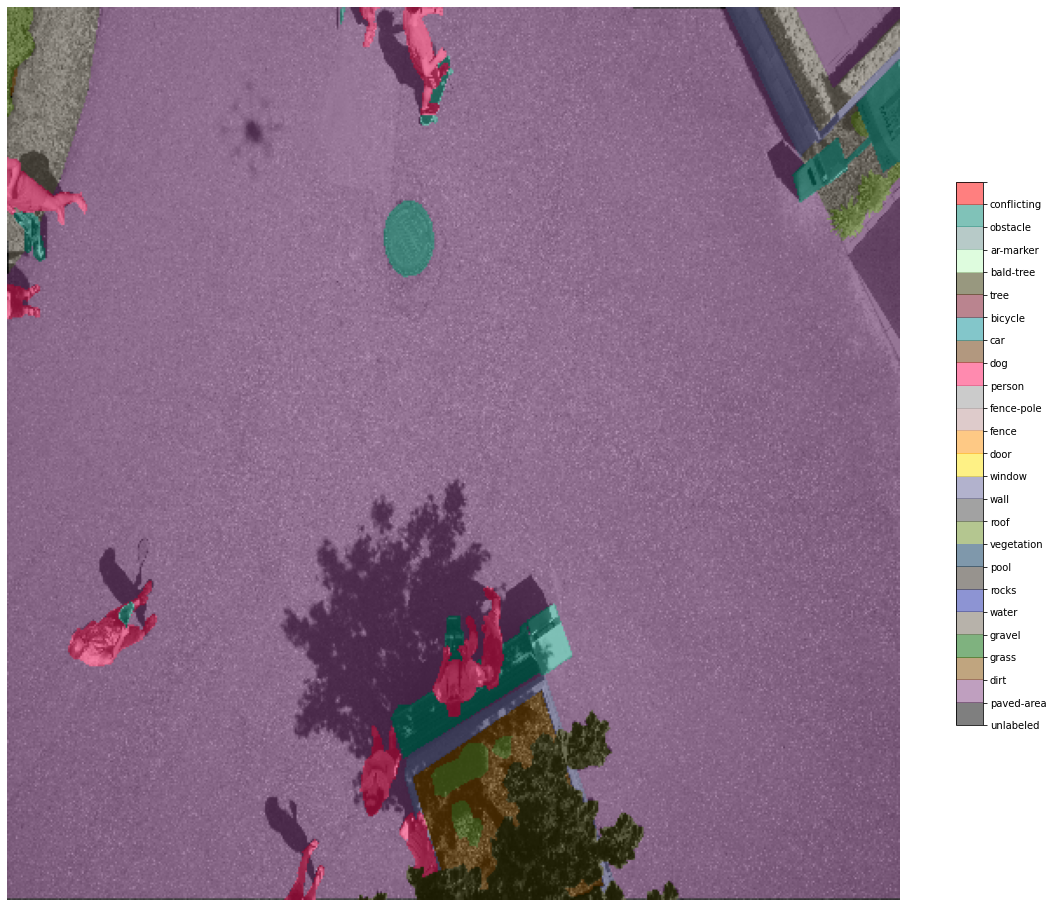

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(raw[:,:,0], cmap=plt.cm.gray) #plot just the first channel in greyscale
plt.imshow(label, cmap=cmap, alpha=0.5, vmin=0, vmax=len(class_dict)) #plot mask with 50% transparency
cbar = plt.colorbar(shrink=0.5, ticks=np.arange(len(class_dict)+1))
cbar.ax.set_yticklabels(labs_txt) 

plt.axis('off')

The `semantic drone` label imagery are RGB (i.e. 3D), unlike the `aeroscapes` labels, which were 2D. We can't work with the RGB label imagery directly, so we need to `flatten` the labels from 3D to 2D, by converting each vector of unique vector of RGB color codes into a single numeric label

In [ ]:
def flatten_labels(im, labs):
   M = []
   for k in range(len(labs)):
      cols = list(labs[k])#[1:]
      msk = ((im[:,:,0]==cols[0])==1) & ((im[:,:,1]==cols[1])==1) & ((im[:,:,2]==cols[2])==1)
      msk = (msk).astype('int')
      M.append(msk)
      del msk

   M2 = [(M[counter]==1)*(1+counter) for counter in range(len(M))]
   msk = np.sum(M2, axis=0)-1
   msk[msk<0] = 0
   return msk

We'll remove the 'unlabeled' category that we don't know what to do with

In [ ]:
labs = [c[1:] for c in class_dict]
print(labs)

[(0, 0, 0), (128, 64, 128), (130, 76, 0), (0, 102, 0), (112, 103, 87), (28, 42, 168), (48, 41, 30), (0, 50, 89), (107, 142, 35), (70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12), (190, 153, 153), (153, 153, 153), (255, 22, 96), (102, 51, 0), (9, 143, 150), (119, 11, 32), (51, 51, 0), (190, 250, 190), (112, 150, 146), (2, 135, 115), (255, 0, 0)]


In [ ]:
labs_txt = [l[0] for l in class_dict]

Let's test our image flattening function 

In [ ]:
msk = flatten_labels(label, labs)

Before we plot, we'll need a colormap. Last time we defined out own colormap with discrete colors. This time I'll show you a different way, if you just want arbitrary colors

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('cubehelix', len(labs))

Now we have a discrete colormap so we can color-code our semi-transparent overlay

(-0.5, 511.5, 511.5, -0.5)

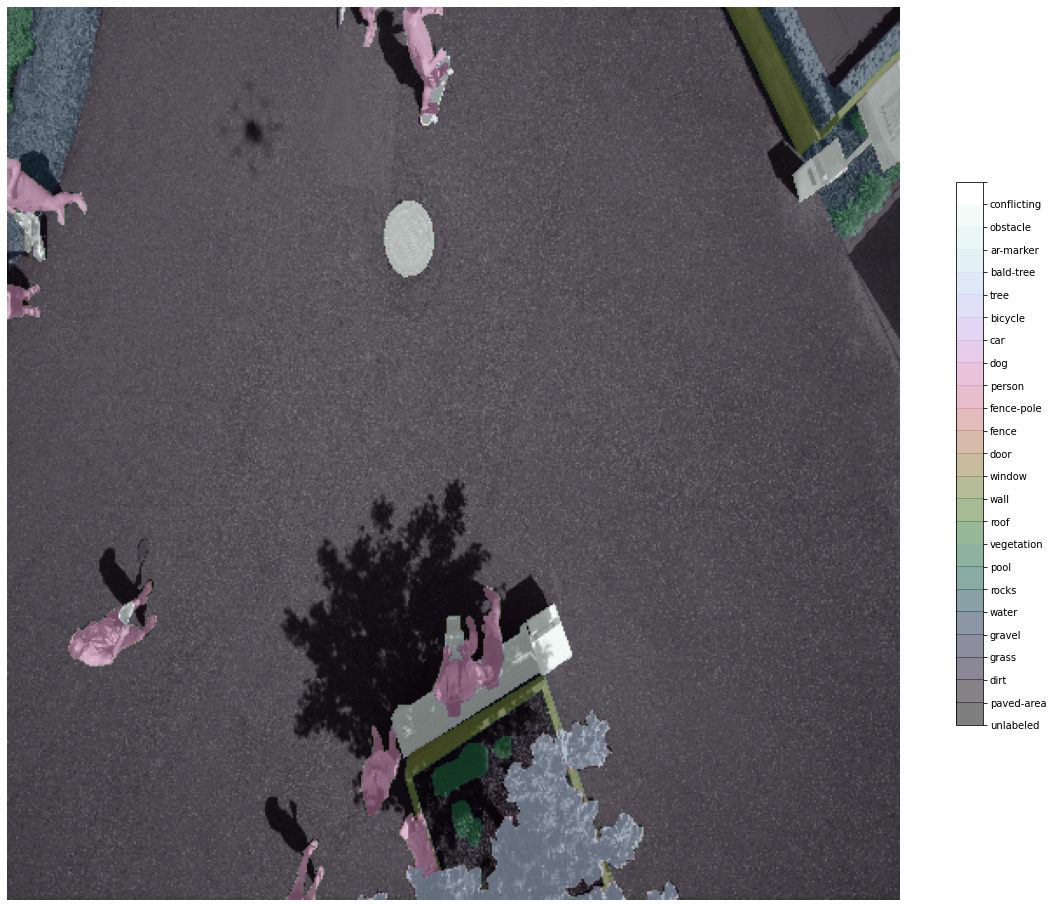

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(raw[:,:,0], cmap=plt.cm.gray) #plot just the first channel in greyscale
plt.imshow(msk, cmap=cmap, alpha=0.5, vmin=0, vmax=len(class_dict)) #plot mask with 50% transparency
cbar = plt.colorbar(shrink=0.5, ticks=np.arange(len(class_dict)+1))
cbar.ax.set_yticklabels(labs_txt) 

plt.axis('off')

### Preparing for model training

There are in fact a few 'vegetation' classes in the semantic drone dataset

In [ ]:
class_foreground = ['vegetation', 'tree', 'grass'] # a list of the classes we want to predict. The list could alternative contain just one class

Each of the 3 vegetation classes have a unique code associated with them, so this next bit discovers what those codes are, and makes a list. We'll use that list to make a binary mask of all three vegetation types versus 'background'

In [ ]:
N = []

for c in class_foreground:
  class_num = [n for n in range(len(labs_txt)) if labs_txt[n]==c][0]
  print(class_num)
  # you can verify this by 
  print(class_dict[class_num])
  N.append(class_num)

8
('vegetation', 107, 142, 35)
19
('tree', 51, 51, 0)
3
('grass', 0, 102, 0)


In [ ]:
N

[8, 19, 3]

In order to train a neural network to segment the image, we will need to define a image and label batch generator function

The next function is an image batch generator. A `generator` is a special type of python function that `yields` a set of data. In our case, it will yield a set of 8 (because that is the batch size) images and labels drawn randomly from the entire set of `files` provided

In [ ]:
def image_batch_generator(files, N, sz, batch_size = 8):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:
        mask, image = get_pair(f, f.replace('.jpg','.png'), sz)
        batch_x.append(image)
       
        tmp = flatten_labels(mask, labs)
        mask = np.array(tmp == N[0]).astype('int')
        for n in N[1:]:
          mask += np.array(tmp == n).astype('int')
        
        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x) #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

Make a generator instance and get a batch of images (`x`) and labels (`y`), just like before

In [ ]:
gen = image_batch_generator(images, N, sz, batch_size)
x, y = next(gen)

which images contain the class(es). 1 means yes

In [ ]:
[tmp.max() for tmp in y]

[1, 1, 1, 1, 1, 1, 1, 1]

Plot the batch

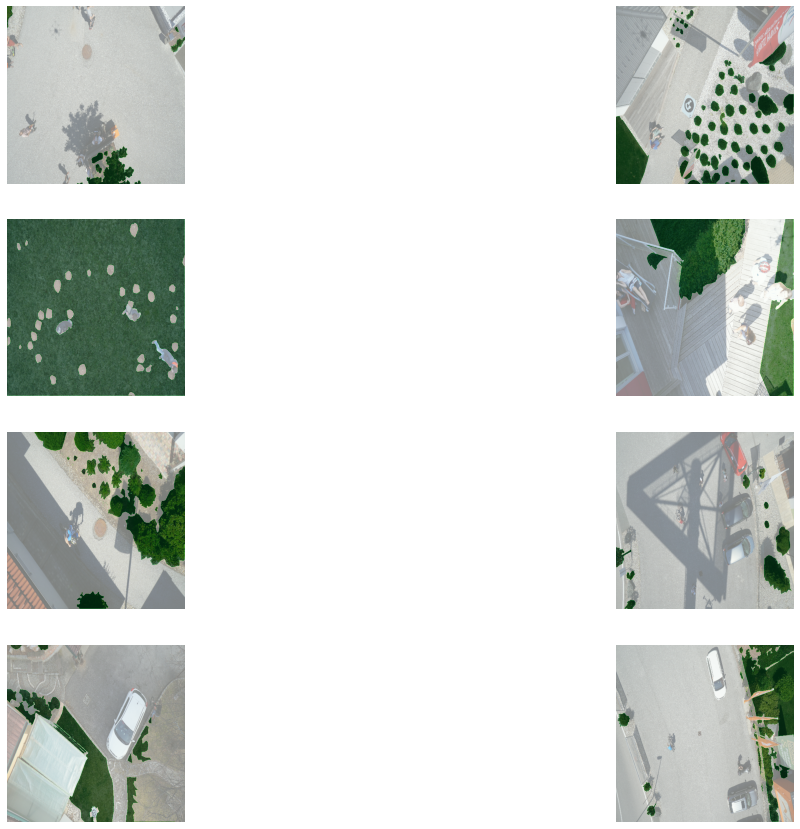

In [ ]:
plt.figure(figsize=(20,15))

counter = 0
for k in range(batch_size):
  plt.subplot(4,2,counter+1)
  plt.imshow(x[counter],  cmap=plt.cm.gray)
  plt.imshow(y[counter].squeeze(), alpha=0.5, cmap=plt.cm.Greens)
  plt.axis('off')
  counter += 1

### Prepare the train, test and validation splits

In [ ]:
train_files = []
# open file and read the content in a list
with open('semanticdrone_train_files.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]
        # add item to the list
        train_files.append(currentPlace)

#do the same for the test files
test_files = []
with open('semanticdrone_test_files.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        test_files.append(currentPlace)

# and again for the validation files
val_files = []
with open('semanticdrone_val_files.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        val_files.append(currentPlace)

In [ ]:
print("Number training files: %i" % (len(train_files)))
print("Number validation files: %i" % (len(val_files)))
print("Number testing files: %i" % (len(test_files)))

Number training files: 50
Number validation files: 25
Number testing files: 25


### Train the model

Once again, time constrains means we'll limit this to 5 epochs

In [ ]:
max_epochs = 5

Next, set up a name for the `.h5` file that will be used to store model weights.

Finally, we train the model by calling the `.fit()` command and providing all the generators and hyperparameters defined in the callbacks

The number of training and validation steps is simply the number of respective files divided by the batch size

In [ ]:
filepath = 'cold_semanticdrone_weights_veg_uresnet'+str(batch_size)+'.h5'

train_generator = image_batch_generator(train_files, N, sz, batch_size = batch_size)
val_generator  = image_batch_generator(val_files, N, sz, batch_size = batch_size)
train_steps = len(train_files) //batch_size
val_steps = len(val_files) //batch_size
print(train_steps)
print(val_steps)

6
3


Make a new model with the same image size and batch number as before

In [ ]:
model_cold = res_unet(sz + (3,), batch_size)
model_cold.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef, mean_iou])

### Train the model with a 'cold start'

The weights are essentially random numbers, so the model has to learn completely from scratch

(5 mins)

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.5182 - dice_coef: 0.4818 - mean_iou: 0.3404i= 1 loss= 0.5181946158409119 val_loss= 0.49813684821128845 dice_coef= 0.48180532455444336 val_dice_coef= 0.5018631815910339 mean_iou= 0.34041455388069153 val_mean_iou= 0.34364327788352966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


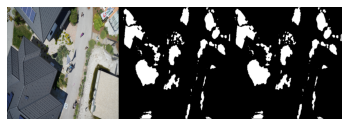

6/6 [==============================] - 62s 10s/step - loss: 0.5182 - dice_coef: 0.4818 - mean_iou: 0.3404 - val_loss: 0.4981 - val_dice_coef: 0.5019 - val_mean_iou: 0.3436
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.3333 - dice_coef: 0.6667 - mean_iou: 0.5547i= 2 loss= 0.3333492577075958 val_loss= 0.43309709429740906 dice_coef= 0.6666507124900818 val_dice_coef= 0.5669029355049133 mean_iou= 0.55473393201828 val_mean_iou= 0.40251266956329346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


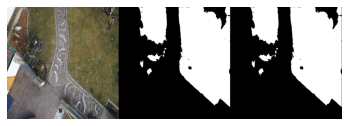

6/6 [==============================] - 61s 10s/step - loss: 0.3333 - dice_coef: 0.6667 - mean_iou: 0.5547 - val_loss: 0.4331 - val_dice_coef: 0.5669 - val_mean_iou: 0.4025
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.3746 - dice_coef: 0.6254 - mean_iou: 0.4904i= 3 loss= 0.374582439661026 val_loss= 0.9977551102638245 dice_coef= 0.6254175305366516 val_dice_coef= 0.002244856907054782 mean_iou= 0.49039578437805176 val_mean_iou= 0.0008709635585546494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


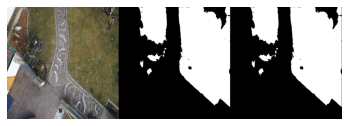

6/6 [==============================] - 61s 10s/step - loss: 0.3746 - dice_coef: 0.6254 - mean_iou: 0.4904 - val_loss: 0.9978 - val_dice_coef: 0.0022 - val_mean_iou: 8.7096e-04
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 0.3909 - dice_coef: 0.6091 - mean_iou: 0.4497i= 4 loss= 0.3909001648426056 val_loss= 0.5039491057395935 dice_coef= 0.6090998649597168 val_dice_coef= 0.4960509240627289 mean_iou= 0.44966819882392883 val_mean_iou= 0.3334912359714508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


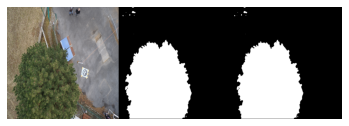

6/6 [==============================] - 60s 10s/step - loss: 0.3909 - dice_coef: 0.6091 - mean_iou: 0.4497 - val_loss: 0.5039 - val_dice_coef: 0.4961 - val_mean_iou: 0.3335
Epoch 5/5
6/6 [==============================] - ETA: 0s - loss: 0.2319 - dice_coef: 0.7681 - mean_iou: 0.6408i= 5 loss= 0.23190343379974365 val_loss= 0.9614138603210449 dice_coef= 0.7680966258049011 val_dice_coef= 0.03858616575598717 mean_iou= 0.6408419013023376 val_mean_iou= 0.019938752055168152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


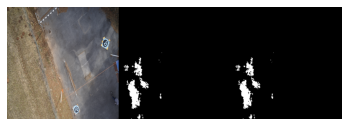

6/6 [==============================] - 59s 10s/step - loss: 0.2319 - dice_coef: 0.7681 - mean_iou: 0.6408 - val_loss: 0.9614 - val_dice_coef: 0.0386 - val_mean_iou: 0.0199


In [ ]:
hist_cold = model_cold.fit(train_generator, 
                epochs = max_epochs, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = build_callbacks(filepath))	

### Training a model with a 'warm' start

This time we'll make a model and load the aeroscape vegetation weights that we generated earlier over 5 traning epochs. This initializes the model with weights that are more meaningful than random numbers, giving the model a headstart

In [ ]:
filepath = 'warm_semanticdrone_weights_veg_uresnet'+str(batch_size)+'.h5'

model_warm = res_unet(sz + (3,), batch_size)
model_warm.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef, mean_iou])

# transfer learning here:
model_warm.load_weights('aeroscapes_weights_veg_uresnet8.h5')

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.1969 - dice_coef: 0.8031 - mean_iou: 0.6806i= 1 loss= 0.1968597173690796 val_loss= 0.25090816617012024 dice_coef= 0.8031403422355652 val_dice_coef= 0.7490918040275574 mean_iou= 0.6805564761161804 val_mean_iou= 0.6095088124275208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


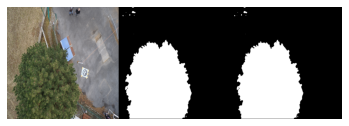

6/6 [==============================] - 61s 10s/step - loss: 0.1969 - dice_coef: 0.8031 - mean_iou: 0.6806 - val_loss: 0.2509 - val_dice_coef: 0.7491 - val_mean_iou: 0.6095
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.1903 - dice_coef: 0.8097 - mean_iou: 0.6912i= 2 loss= 0.19033201038837433 val_loss= 0.19531308114528656 dice_coef= 0.8096680045127869 val_dice_coef= 0.804686963558197 mean_iou= 0.6912143230438232 val_mean_iou= 0.6753719449043274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


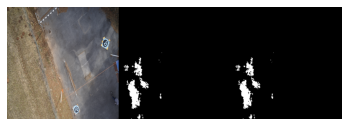

6/6 [==============================] - 59s 10s/step - loss: 0.1903 - dice_coef: 0.8097 - mean_iou: 0.6912 - val_loss: 0.1953 - val_dice_coef: 0.8047 - val_mean_iou: 0.6754
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.1540 - dice_coef: 0.8460 - mean_iou: 0.7357i= 3 loss= 0.15399032831192017 val_loss= 0.25222015380859375 dice_coef= 0.8460096716880798 val_dice_coef= 0.7477798461914062 mean_iou= 0.7356805205345154 val_mean_iou= 0.6196593642234802


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


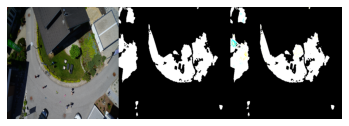

6/6 [==============================] - 59s 10s/step - loss: 0.1540 - dice_coef: 0.8460 - mean_iou: 0.7357 - val_loss: 0.2522 - val_dice_coef: 0.7478 - val_mean_iou: 0.6197
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 0.2183 - dice_coef: 0.7817 - mean_iou: 0.6489i= 4 loss= 0.218266561627388 val_loss= 0.19223248958587646 dice_coef= 0.7817334532737732 val_dice_coef= 0.8077674508094788 mean_iou= 0.6489102244377136 val_mean_iou= 0.6820290088653564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


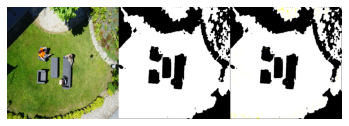

6/6 [==============================] - 59s 10s/step - loss: 0.2183 - dice_coef: 0.7817 - mean_iou: 0.6489 - val_loss: 0.1922 - val_dice_coef: 0.8078 - val_mean_iou: 0.6820
Epoch 5/5
6/6 [==============================] - ETA: 0s - loss: 0.1773 - dice_coef: 0.8227 - mean_iou: 0.7036i= 5 loss= 0.17730195820331573 val_loss= 0.22414769232273102 dice_coef= 0.8226980566978455 val_dice_coef= 0.7758522629737854 mean_iou= 0.7035523056983948 val_mean_iou= 0.6423369646072388


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


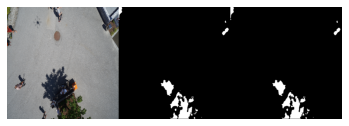

6/6 [==============================] - 59s 10s/step - loss: 0.1773 - dice_coef: 0.8227 - mean_iou: 0.7036 - val_loss: 0.2241 - val_dice_coef: 0.7759 - val_mean_iou: 0.6423


In [ ]:
hist_warm = model_warm.fit(train_generator, 
                epochs = max_epochs, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = build_callbacks(filepath))	

### Training the model with a 'hot start'

This time, we'll initiate the model with the weights obtained on the aeroscapes dataset over 100 epochs

In [ ]:
filepath = 'hot_semanticdrone_weights_veg_uresnet'+str(batch_size)+'.h5'

model_hot = res_unet(sz + (3,), batch_size)
model_hot.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef, mean_iou])

model_hot.load_weights('aeroscapes_weights_vegetation_uresnet8_100epochs.h5')

(5 mins)

Epoch 1/5
6/6 [==============================] - ETA: 0s - loss: 0.2294 - dice_coef: 0.7706 - mean_iou: 0.6386i= 1 loss= 0.22940926253795624 val_loss= 0.45013871788978577 dice_coef= 0.7705907225608826 val_dice_coef= 0.5498612523078918 mean_iou= 0.6386273503303528 val_mean_iou= 0.3942875862121582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


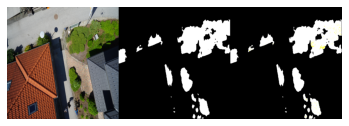

6/6 [==============================] - 62s 10s/step - loss: 0.2294 - dice_coef: 0.7706 - mean_iou: 0.6386 - val_loss: 0.4501 - val_dice_coef: 0.5499 - val_mean_iou: 0.3943
Epoch 2/5
6/6 [==============================] - ETA: 0s - loss: 0.2073 - dice_coef: 0.7927 - mean_iou: 0.6700i= 2 loss= 0.20727069675922394 val_loss= 0.5589658617973328 dice_coef= 0.7927293181419373 val_dice_coef= 0.4410341680049896 mean_iou= 0.6699807643890381 val_mean_iou= 0.2845879793167114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


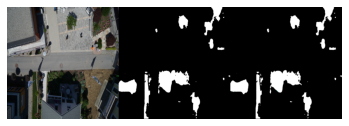

6/6 [==============================] - 60s 10s/step - loss: 0.2073 - dice_coef: 0.7927 - mean_iou: 0.6700 - val_loss: 0.5590 - val_dice_coef: 0.4410 - val_mean_iou: 0.2846
Epoch 3/5
6/6 [==============================] - ETA: 0s - loss: 0.1740 - dice_coef: 0.8260 - mean_iou: 0.7177i= 3 loss= 0.1739850491285324 val_loss= 0.4335451126098633 dice_coef= 0.8260149359703064 val_dice_coef= 0.5664548873901367 mean_iou= 0.7176517844200134 val_mean_iou= 0.42363110184669495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


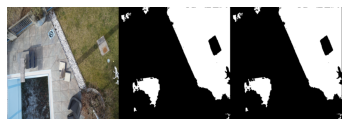

6/6 [==============================] - 60s 10s/step - loss: 0.1740 - dice_coef: 0.8260 - mean_iou: 0.7177 - val_loss: 0.4335 - val_dice_coef: 0.5665 - val_mean_iou: 0.4236
Epoch 4/5
6/6 [==============================] - ETA: 0s - loss: 0.1868 - dice_coef: 0.8132 - mean_iou: 0.6933i= 4 loss= 0.18682479858398438 val_loss= 0.3167407214641571 dice_coef= 0.8131752014160156 val_dice_coef= 0.6832592487335205 mean_iou= 0.6933004260063171 val_mean_iou= 0.5633461475372314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


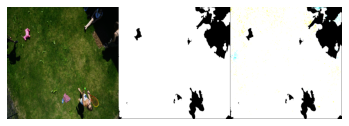

6/6 [==============================] - 60s 10s/step - loss: 0.1868 - dice_coef: 0.8132 - mean_iou: 0.6933 - val_loss: 0.3167 - val_dice_coef: 0.6833 - val_mean_iou: 0.5633
Epoch 5/5
6/6 [==============================] - ETA: 0s - loss: 0.1391 - dice_coef: 0.8609 - mean_iou: 0.7573i= 5 loss= 0.1391456574201584 val_loss= 0.4751490652561188 dice_coef= 0.8608543276786804 val_dice_coef= 0.5248509049415588 mean_iou= 0.7573192715644836 val_mean_iou= 0.36255335807800293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


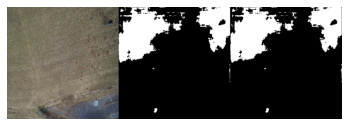

6/6 [==============================] - 59s 10s/step - loss: 0.1391 - dice_coef: 0.8609 - mean_iou: 0.7573 - val_loss: 0.4751 - val_dice_coef: 0.5249 - val_mean_iou: 0.3626


In [ ]:
hist_hot = model_hot.fit(train_generator, 
                epochs = max_epochs, steps_per_epoch = train_steps,
                validation_data = val_generator, validation_steps = val_steps,
                callbacks = build_callbacks(filepath))	

### Comparing the three model training strategies

Let's make a plot of the histories of both train and validation losses and dice coefficients, and also the history of the learning rate

Text(0, 0.5, 'Loss')

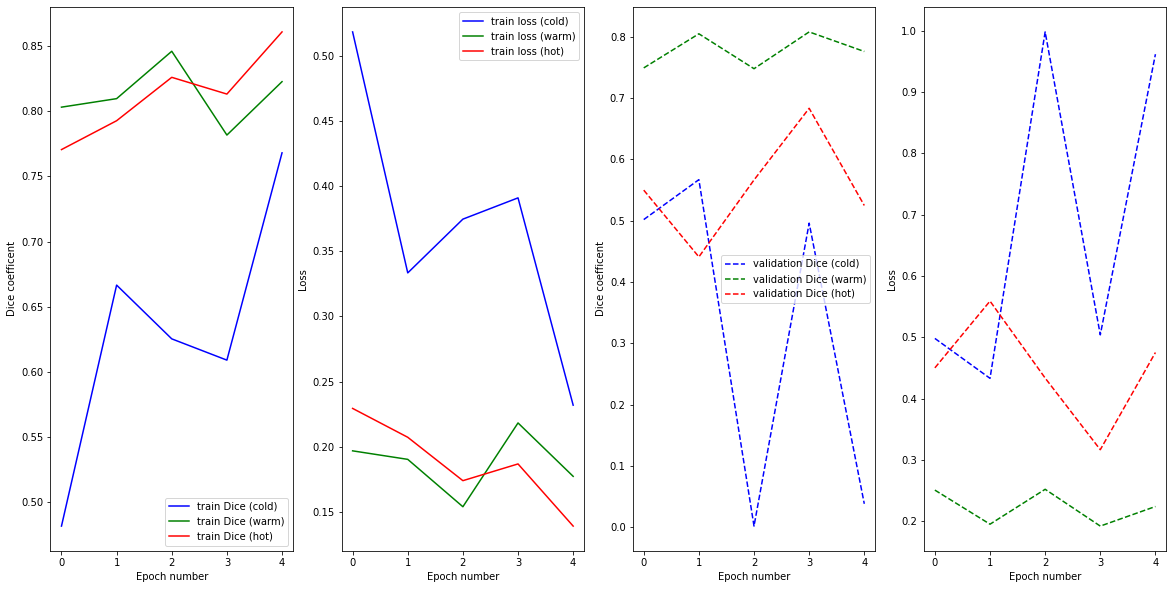

In [ ]:
plt.figure(figsize=(20,10))

## training metrics
plt.subplot(141)
plt.plot(hist_cold.history['dice_coef'], 'b', label='train Dice (cold)')

plt.plot(hist_warm.history['dice_coef'], 'g', label='train Dice (warm)')

plt.plot(hist_hot.history['dice_coef'], 'r', label='train Dice (hot)')

plt.xlabel('Epoch number'); plt.ylabel('Dice coefficent')
plt.legend()

plt.subplot(142)
plt.plot(hist_cold.history['loss'], 'b', label='train loss (cold)')

plt.plot(hist_warm.history['loss'], 'g', label='train loss (warm)')

plt.plot(hist_hot.history['loss'], 'r', label='train loss (hot)')

plt.xlabel('Epoch number'); plt.ylabel('Loss')
plt.legend()

## validation metrics
plt.subplot(143)
plt.plot(hist_cold.history['val_dice_coef'], 'b--', label='validation Dice (cold)')

plt.plot(hist_warm.history['val_dice_coef'], 'g--', label='validation Dice (warm)')

plt.plot(hist_hot.history['val_dice_coef'], 'r--', label='validation Dice (hot)')

plt.xlabel('Epoch number'); plt.ylabel('Dice coefficent')
plt.legend()

plt.subplot(144)
plt.plot(hist_cold.history['val_loss'], 'b--', label='validation loss (cold)')

plt.plot(hist_warm.history['val_loss'], 'g--', label='validation loss (warm)')

plt.plot(hist_hot.history['val_loss'], 'r--', label='validation loss (hot)')

plt.xlabel('Epoch number'); plt.ylabel('Loss')


As you can see, the 'hot' (red) are 'warm' (green) more accurate than the 'cold' (blue) model, with a larger Dice coefficients and smaller loss values. There is marginal advantage oof the hot model over the warm model for this class (vegetation), but that is not true of other classes. 

I encourage you to experiment with other classes to see how much variability there is in model performance and hot-starting 

Get the test scores for each model

In [ ]:
test_generator = image_batch_generator(test_files, N, sz, batch_size = batch_size)

print("# test files: %i" % (len(test_files)))

# some other training parameters
steps = len(test_files) // batch_size

# test files: 25


We'll each have slightly different results because slightly different batches would have been selected during model training, but you should see that the mean Dice score the cold-start model is much lower than the warm and hot start models. On average, the hot start model has the best score

In [ ]:
scores = model_cold.evaluate(test_generator, steps=steps) 
print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

3/3 [==============================] - 12s 4s/step - loss: 0.9243 - dice_coef: 0.0757 - mean_iou: 0.0415
loss=0.9243, Mean Dice=0.0757


In [ ]:
scores = model_warm.evaluate(test_generator, steps=steps) 
print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

3/3 [==============================] - 12s 4s/step - loss: 0.1926 - dice_coef: 0.8074 - mean_iou: 0.6797
loss=0.1926, Mean Dice=0.8074


In [ ]:
scores = model_hot.evaluate(test_generator, steps=steps) 
print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

3/3 [==============================] - 12s 4s/step - loss: 0.4590 - dice_coef: 0.5410 - mean_iou: 0.3955
loss=0.4590, Mean Dice=0.5410


Finally, we end with some more pretty pictures (outputs from the hot-start model)

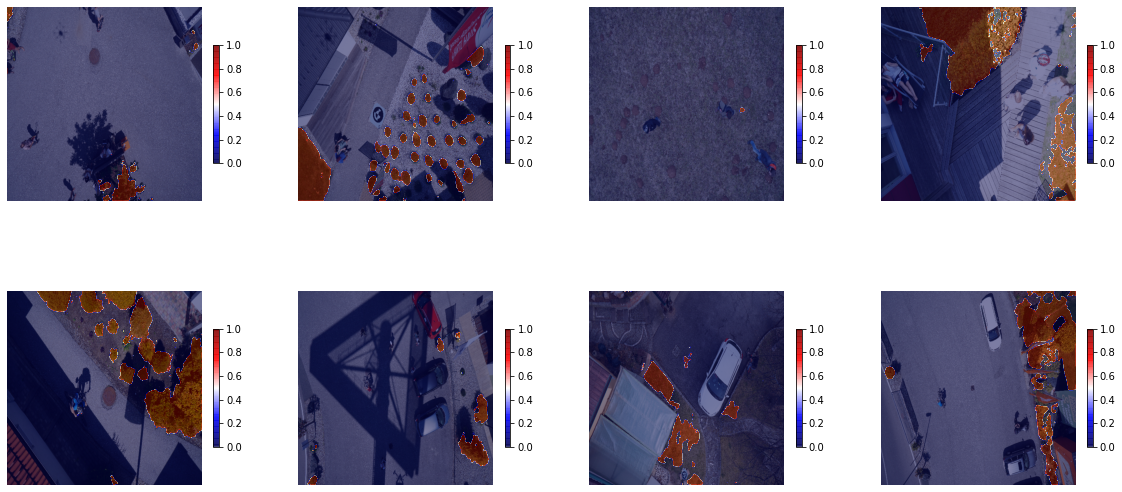

In [ ]:
plt.figure(figsize=(20,20))

orig_size = (720, 720)

for k in range(batch_size):
  plt.subplot(4,4,k+1)

  resized_image = Image.fromarray(x[k]).resize(orig_size)
  plt.imshow(resized_image)

  #predict the mask 
  # we expand the dimensions (because the model needs a 4d tensor input) then squeeze the 
  # output dimensions down from 3d to 2d
  pred = model_hot.predict(np.expand_dims(x[k], 0)).squeeze()

  resized_label = np.array(Image.fromarray(pred).resize(orig_size))

  #mask post-processing 
  # we used the sigmoid function in our classifying layer, so what we get back
  # is a range of values beween 0 and 1 that are like probability scores
  # I used a threshold of 0.5, but that could be different if you knew different
  msk  = (resized_label>0.5).astype('int')   

  plt.imshow(msk, alpha=0.5, cmap=plt.cm.seismic)
  plt.colorbar(shrink=0.5)
  plt.axis('off')

Hopefully that gives you a few ideas you can take to your own projects. Be experimental, and get familiar with workflows that can turn your own data and labels into suitable formats for training a model. Unfortunately models are typically trained on relatively small imagery (typically up to 2000 ish square pixels, but more typically less than 1000 square pixels, like here), due to GPU memory limitations

### Going Further

I encourage you to go back and train for more epochs, different classes, etc. See what classes work well and which do not (clue: it generally relates to the average number of pixels and frequency of the class within the set). Try with your own data!

In part 2, we use the UNet model that we used here and use it for multiclass segmentation